# Data preprocessing and analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('data/raw-loneliness-dataset-2018.csv')

# Compute dataset statistics

In [3]:
doc_count = df.shape[0]
abstract_structured_count = sum(df['abstract_structured'])

# filter: older adults, note here we count 'maybe' as '1'
OA_counts = df['filter_OA_include'].value_counts()
OA_in_count = OA_counts['1']
OA_out_count = OA_counts['0']
OA_maybe_count = OA_counts['maybe']
OA_selectivity = (OA_in_count + OA_maybe_count) / doc_count

# filter: study, note here we count 'maybe' as '1'
study_counts = df['filter_study_include'].value_counts()
study_in_count = study_counts['1']
study_out_count = study_counts['0']
study_maybe_count = study_counts['maybe']
study_selectivity = (study_in_count + study_maybe_count) / doc_count

# screening labels, note here we count 'maybe' as '1'
doc_in_count = df.loc[(df['filter_study_include'].isin(['1', 'maybe'])) & (df['filter_OA_include'].isin(['1', 'maybe']))].shape[0]
doc_in_prop = doc_in_count / doc_count

### Plot predicate characteristics

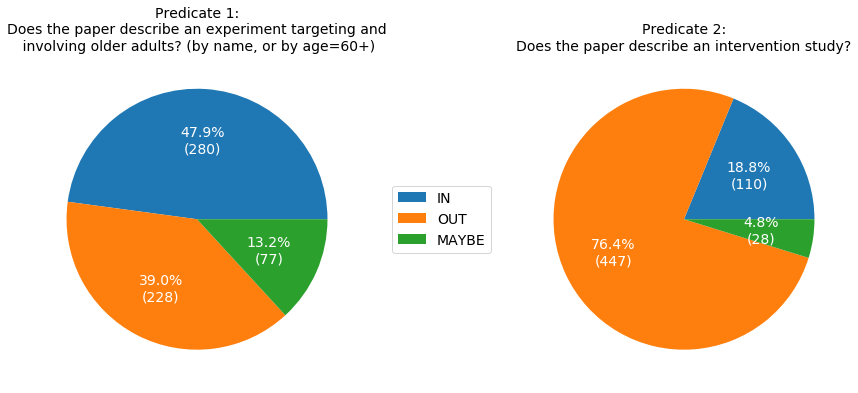

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), subplot_kw=dict(aspect="equal"))
labels = ['IN', 'OUT', 'MAYBE']


def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d})".format(pct, absolute)

# Predicate 
data1 = [OA_in_count, OA_out_count, OA_maybe_count]
wedges, texts, autotexts = ax1.pie(data1, autopct=lambda pct: func(pct, data1),
                                  textprops={'fontsize': 14, 'color': 'w'})
ax1.legend(wedges, 
          labels,
          loc="center",
          bbox_to_anchor=(1, 0, 0.5, 1), 
          fontsize=14)
ax1.set_title("Predicate 1:\nDoes the paper describe an experiment targeting and\n involving older adults? (by name, or by age=60+)", size=14)


# Predicate 2
data2 = [study_in_count, study_out_count, study_maybe_count]
wedges, texts, autotexts = ax2.pie(data2, autopct=lambda pct: func(pct, data2),
                                  textprops={'fontsize': 14, 'color': 'w'})
ax2.set_title("Predicate 2:\nDoes the paper describe an intervention study?", size=14)
# plt.setp(autotexts, size=14, weight="bold")

plt.show()

<b>Dataset size: 585 abstracts<br/>
Selectivity of Predicate1: 0.61<br/>
Selectivity of Predicate2: 0.23</b> <br/><br/>
*Selectivity is the proportion of documents that satisfy a predicate.<br/>

### Plot the structure of abstracs

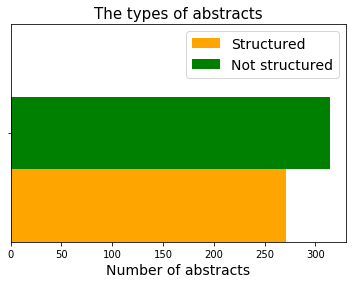

In [5]:
df2 = pd.DataFrame(dict(graph=[''],
                           structured=[abstract_structured_count], 
                           not_structured=[doc_count-abstract_structured_count])) 
ind = np.arange(len(df2))
width = 0.4

fig, ax = plt.subplots()
ax.barh(ind, df2.structured, width, color='orange', label='Structured')
ax.barh(ind + width, df2.not_structured, width, color='green', label='Not structured')

ax.set(yticks=ind + width, yticklabels=df2.graph, ylim=[2*width - 1, len(df2)])
ax.legend(fontsize=14)
ax.set_xlabel('Number of abstracts', fontsize=14)
ax.set_title('The types of abstracts', fontsize=15)
plt.show()

# Data preprocessing

In [6]:
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
import nltk

import string
import re

In [7]:
df['text'] = df[['Title', 'Abstract']].apply(lambda x: '. '.join(x), axis=1)

text_cleaned = []

# Replace all numbers with special strings
regx = re.compile(r"\b[\d.]+\b")
porter = PorterStemmer()
wordnet_lemmatizer = WordNetLemmatizer()

for _, row in df.iterrows():
    text = row['text'].replace('Copyright', '').split('©', 1)[0]
    # with stemming
#     text = [porter.stem(word.strip()) for word in nltk.word_tokenize(text.lower()) if (word not in string.punctuation) and (word not in stopwords.words("english"))]
    
#     # without stemming
#     text = [word.strip() for word in nltk.word_tokenize(text.lower()) if (word not in string.punctuation) and (word not in stopwords.words("english"))]
    
    # with lemmatizer
    
    text = [wordnet_lemmatizer.lemmatize(word.strip()) for word in nltk.word_tokenize(text.lower()) if (word not in string.punctuation) and (word not in stopwords.words("english"))]
    text =  ' '.join(str(i) for i in text)
    text_cleaned.append(text)

In [8]:
df['text'] = pd.DataFrame(text_cleaned)
df['oa_predicate'] = df['filter_OA_include'].map({'0': 0, '1': 1, 'maybe': 1})
df['study_predicate'] = df['filter_study_include'].map({'0': 0, '1': 1, 'maybe': 1})
df['Y'] = df.apply(lambda row: 1 if row['oa_predicate']+row['study_predicate'] == 2 else 0, axis=1)


# # uncomment if need to save as csv
# df[['text', 'oa_predicate', 'study_predicate', 'Y', 'abstract_structured']].to_csv('data/clean-loneliness-dataset-2018.csv', index=False)

### Proportion of positive items ( i.e. that satisfy both predicates)

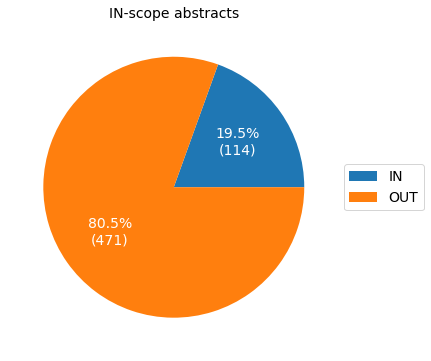

In [9]:
fig, ax = plt.subplots(figsize=(16, 6), subplot_kw=dict(aspect="equal"))
labels = ['IN', 'OUT']
data3 = [sum(df['Y'].values), doc_count - sum(df['Y'].values)]
wedges, texts, autotexts = ax.pie(data3, autopct=lambda pct: func(pct, data3),
                                  textprops={'fontsize': 14, 'color': 'w'})
ax.legend(wedges, 
          labels,
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1), 
          fontsize=14)
ax.set_title("IN-scope abstracts", size=14)
plt.show()